# SVM

In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
def compute_kernel(x,y, kernel, c=1.):
    res = 0.
    if kernel == 'linear':
        res = x.dot(y.T)
    
    if kernel == 'gauss':
        res = np.exp(-0.5 / c * (x-y).dot((x-y).T))
    
    return res


def smo(X, y, C, tol, max_passes, kernel, c):
    m, n = X.shape
    alpha = np.zeros(m)
    b = 0.
    passes = 0
    K = np.zeros((m, m))
    for i in range(m):
        for j in range(i+1):
            K[i][j] = compute_kernel(X[i], X[j], kernel, c)
            K[j][i] = K[i][j]
    
    while (passes < max_passes):
        num_changed_alphas = 0
        for i in range(m):
            E_i = np.sum(alpha * y * K[i]) + b - y[i]
            if (y[i]*E_i<-tol and alpha[i]<C) or (y[i]*E_i>tol and alpha[i]>0):
                j = np.random.permutation(range(i) + range(i+1, m))[0]
                E_j = np.sum(alpha * y * K[j]) + b - y[j]
                alpha_i_old = alpha[i]
                alpha_j_old = alpha[j]
                if (y[i] != y[j]):
                    L = max(0, alpha_j_old - alpha_i_old)
                    H = min(C, C + alpha_j_old - alpha_i_old)
                else:
                    L = max(0, alpha_j_old + alpha_i_old - C)
                    H = min(C, alpha_j_old + alpha_i_old)
                if (L == H):
                    continue
                etha = 2 * K[i][j] - K[i][i] - K[j][j]
                if etha >= 0:
                    continue
                temp = alpha_j_old - y[j] * (E_i - E_j) / etha
                if temp > H:
                    alpha[j] = H
                elif temp > L:
                    alpha[j] = temp
                else:
                    alpha[j] = L
                if abs(alpha[j] - alpha_j_old) < 1e-5:
                    continue
                alpha[i] = alpha_i_old + y[i] * y[j] * (alpha_j_old - alpha[j])
                b1 = b - E_i - y[i] * (alpha[i] - alpha_i_old) * K[i][i] - y[j] * (alpha[j] - alpha_j_old) * K[i][j]
                b2 = b - E_j - y[i] * (alpha[i] - alpha_i_old) * K[i][j] - y[j] * (alpha[j] - alpha_j_old) * K[j][j]
                if 0 < alpha[i] < C:
                    b = b1
                elif 0 < alpha[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2.
                num_changed_alphas += 1
        
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0
    
    w = np.zeros(2)
    w[0] = np.sum(alpha * y * X[:, 0])
    w[1] = np.sum(alpha * y * X[:, 1])

            
    return alpha, b, w
                
                    
def predict(x, alpha, b, X, y, kernel, c):
    res = b
    m = len(y)
    for i in range(m):
        if (alpha[i] != 0.):
            res += alpha[i] * y[i] * compute_kernel(X[i], x, kernel, c)
    if res > 0.:
        target = 1
    else:
        target = -1
    return target





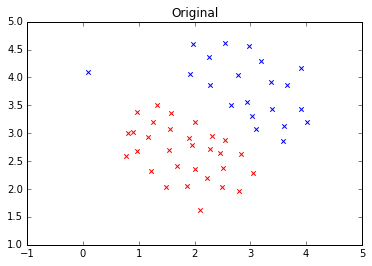

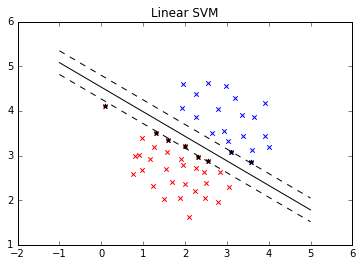

In [3]:
from scipy.io import loadmat

data = loadmat('ex6data1.mat')
X = data['X']
y = data['y'].flatten()
y = 2. * y - 1.
pos_pred = np.where(y == 1)
neg_pred = np.where(y == -1)
plt.scatter(X[pos_pred, 0], X[pos_pred, 1], marker='x', c='b')
plt.scatter(X[neg_pred, 0], X[neg_pred, 1], marker='x', c='r')
plt.title('Original')
plt.show()


C = 5.
tol = 1e-5
max_passes = 10
kernel = 'linear'
c = 1.
alpha, b, w = smo(X, y, C, tol, max_passes, kernel, c)

pred = np.zeros(len(y))
for i in range(len(X)):
    pred[i] = (predict(X[i], alpha, b, X, y, kernel, c))

plt.scatter(X[np.where(pred > 0), 0], X[np.where(pred > 0), 1], marker='x', c='b')
plt.scatter(X[np.where(pred < 0), 0], X[np.where(pred < 0), 1], marker='x', c='r')
plt.scatter(X[np.where(alpha != 0.),0], X[np.where(alpha != 0.),1], marker='*', c='k')
xx = [-1., 5.]
yy = [-1. * b / w[1] - w[0]/w[1]*xx[0], -1. * b / w[1] - w[0]/w[1]*xx[1]]
plt.plot(xx, yy, 'k-')
margin = 1. / np.sqrt(w[0]**2 + w[1]**2)
yy1 = [yy[0] - margin, yy[1] - margin]
yy2 = [yy[0] + margin, yy[1] + margin]
plt.plot(xx, yy1, 'k--')
plt.plot(xx, yy2, 'k--')
plt.title('Linear SVM')
plt.show()


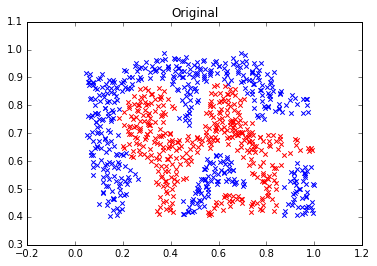

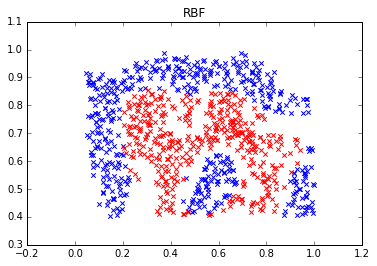

In [4]:
data = loadmat('ex6data2.mat')
X = data['X']
y = data['y'].flatten()
y = 2. * y - 1.
pos_pred = np.where(y == 1)
neg_pred = np.where(y == -1)
plt.scatter(X[pos_pred, 0], X[pos_pred, 1], marker='x', c='b')
plt.scatter(X[neg_pred, 0], X[neg_pred, 1], marker='x', c='r')
plt.title('Original')
plt.show()

C = 5.
tol = 1e-5
max_passes = 5
kernel = 'gauss'
c = 0.05
alpha, b, w = smo(X, y, C, tol, max_passes, kernel, c)

pred = np.zeros(len(y))
for i in range(len(X)):
    pred[i] = (predict(X[i], alpha, b, X, y, kernel, c))

plt.scatter(X[np.where(pred > 0), 0], X[np.where(pred > 0), 1], marker='x', c='b')
plt.scatter(X[np.where(pred < 0), 0], X[np.where(pred < 0), 1], marker='x', c='r')
#plt.scatter(X[np.where(alpha > 0.),0], X[np.where(alpha > 0.),1], marker='*', c='k')
plt.title('RBF')
plt.show()
